<a href="https://colab.research.google.com/github/GOWSALYAR7397/-shopping-mod3-link/blob/main/advancedtimeseriesforecastingwithattentionbasedLSTMs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install --quiet yfinance statsmodels pmdarima scikit-learn matplotlib seaborn tensorflow prophet

print("All packages installed successfully!")


All packages installed successfully!


In [3]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
import datetime
import tensorflow as tf
from keras import layers, Model, Input
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error
from prophet import Prophet

plt.style.use("seaborn-v0_8")
sns.set_palette("deep")


/tmp/ipython-input-2962652344.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(TICKER, start=START, end=END, progress=False)


Data sample:
Price       value       date
Ticker       ^VIX           
0       20.040001 2010-01-04
1       19.350000 2010-01-05
2       19.160000 2010-01-06
3       19.059999 2010-01-07
4       18.129999 2010-01-08


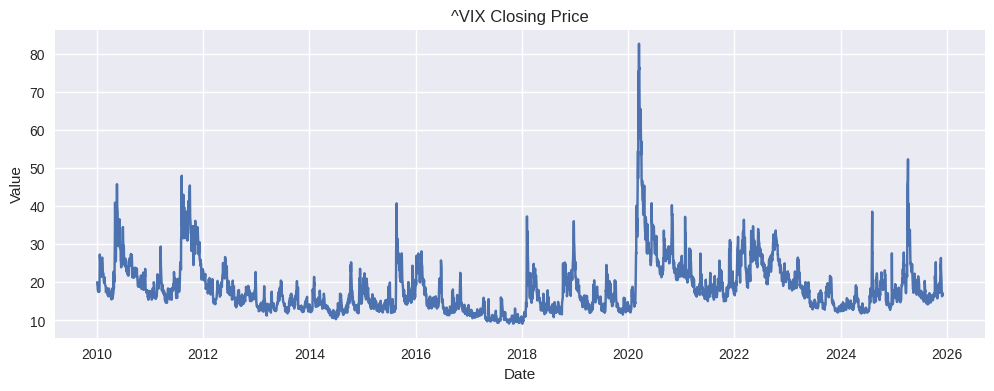

In [4]:
TICKER = "^VIX"
START = "2010-01-01"
END = datetime.date.today().isoformat()

LOOKBACK = 60
HORIZON = 5

# Download
df = yf.download(TICKER, start=START, end=END, progress=False)
df = df[['Close']].rename(columns={'Close':'value'})
df['date'] = df.index
df = df.reset_index(drop=True)

print("Data sample:")
print(df.head())

# Plot data
plt.figure(figsize=(12,4))
plt.plot(df['date'], df['value'])
plt.title(f"{TICKER} Closing Price")
plt.xlabel("Date")
plt.ylabel("Value")
plt.show()


In [5]:
def adf_test(series, name='Series', alpha=0.05):
    result = adfuller(series.dropna())
    print(f"ADF Test on {name}")
    print(f"Test Statistic : {result[0]:.4f}")
    print(f"p-value        : {result[1]:.4f}")
    print(f"#Lags Used     : {result[2]}")
    print(f"#Observations  : {result[3]}")
    print("Critical Values:")
    for key, value in result[4].items():
        print(f"   {key}: {value:.4f}")
    if result[1] < alpha:
        print("=> The series is stationary.")
    else:
        print("=> The series is NOT stationary.")

adf_test(df['value'], name=TICKER)


ADF Test on ^VIX
Test Statistic : -5.4801
p-value        : 0.0000
#Lags Used     : 26
#Observations  : 3977
Critical Values:
   1%: -3.4320
   5%: -2.8623
   10%: -2.5672
=> The series is stationary.


In [6]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_values = scaler.fit_transform(df[['value']])

def create_sequences(data, lookback, horizon):
    X, y = [], []
    for i in range(len(data)-lookback-horizon+1):
        X.append(data[i:i+lookback,0])
        y.append(data[i+lookback:i+lookback+horizon,0])
    X = np.array(X)
    y = np.array(y)
    return X.reshape(X.shape[0], lookback,1), y

X, y = create_sequences(scaled_values, LOOKBACK, HORIZON)
print(f"X shape: {X.shape}, y shape: {y.shape}")


X shape: (3940, 60, 1), y shape: (3940, 5)


In [7]:
train_size = int(len(X)*0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

horizon = y.shape[1]
enc_units = 64
dec_units = 64

decoder_train = np.zeros((X_train.shape[0], horizon,1))
decoder_test  = np.zeros((X_test.shape[0], horizon,1))

class BahdanauAttention(layers.Layer):
    def __init__(self, units):
        super().__init__()
        self.W1 = layers.Dense(units)
        self.W2 = layers.Dense(units)
        self.V  = layers.Dense(1)
    def call(self, encoder_output, decoder_hidden):
        hidden_with_time = tf.expand_dims(decoder_hidden,1)
        score = self.V(tf.nn.tanh(self.W1(encoder_output)+self.W2(hidden_with_time)))
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = tf.reduce_sum(attention_weights*encoder_output, axis=1)
        return context_vector

# Encoder
encoder_inputs = Input(shape=(X.shape[1],1))
encoder_lstm = layers.LSTM(enc_units, return_sequences=True, return_state=True)
encoder_output, state_h, state_c = encoder_lstm(encoder_inputs)

# Decoder
decoder_inputs = Input(shape=(horizon,1))
decoder_lstm = layers.LSTM(dec_units, return_sequences=True, return_state=True)
attention = BahdanauAttention(dec_units)

all_outputs = []
decoder_state_h = state_h
decoder_state_c = state_c
step_input = layers.Lambda(lambda x: x[:,0:1,:])(decoder_inputs)

for t in range(horizon):
    context = attention(encoder_output, decoder_state_h)
    context = layers.Reshape((1, dec_units))(context)
    combined = layers.Concatenate(axis=-1)([step_input, context])
    lstm_out, decoder_state_h, decoder_state_c = decoder_lstm(combined, initial_state=[decoder_state_h, decoder_state_c])
    output = layers.Dense(1)(lstm_out)
    all_outputs.append(output)
    if t+1 < horizon:
        step_input = layers.Lambda(lambda x, step=t: x[:,step+1:step+2,:])(decoder_inputs)
    else:
        step_input = output

decoder_outputs = layers.Concatenate(axis=1)(all_outputs)
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer="adam", loss="mse")
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 60, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ [(None, 60, 64),  │     16,896 │ input_layer_3[0]… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_4       │ (None, 5, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bahdanau_attention… │ (None, 64)        │      8,385 │ lstm_3[0][0],     │
│ (BahdanauAttention) │                   │            │ lstm_3[0][1],     │
│                     │                   │            │ lstm_3[0][0],     │
│                     │                   │            │ lstm_4[0][1],     │
│                     │                   │            │ lstm_3[0][0],     │
│                     │                   │            │ lstm_4[1][1],     │
│                     │                   │            │ lstm_3[0][0],     │
│                     │                   │            │ lstm_4[2][1],     │
│                     │                   │            │ lstm_3[0][0],     │
│                     │                   │            │ lstm_4[3][1]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_5 (Lambda)   │ (None, 1, 1)      │          0 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_5 (Reshape) │ (None, 1, 64)     │          0 │ bahdanau_attenti… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 1, 65)     │          0 │ lambda_5[0][0],   │
│ (Concatenate)       │                   │            │ reshape_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ [(None, 1, 64),   │     33,280 │ concatenate_6[0]… │
│                     │ (None, 64),       │            │ lstm_3[0][1],     │
│                     │ (None, 64)]       │            │ lstm_3[0][2],     │
│                     │                   │            │ concatenate_7[0]… │
│                     │                   │            │ lstm_4[0][1],     │
│                     │                   │            │ lstm_4[0][2],     │
│                     │                   │            │ concatenate_8[0]… │
│                     │                   │            │ lstm_4[1][1],     │
│                     │                   │            │ lstm_4[1][2],     │
│                     │                   │            │ concatenate_9[0]… │
│                     │                   │            │ lstm_4[2][1],     │
│                     │                   │            │ lstm_4[2][2],     │
│                     │                   │            │ concatenate_10[0… │
│                     │                   │            │ lstm_4[3][1],     │
│                     │                   │            │ lstm_4[3][2]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_6 (Lambda)   │ (None, 1, 1)      │          0 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_6 (Reshape) │ (None, 1, 64)     │          0 │ bahdanau_attenti… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_7       │ (None, 1, 65)     │          0 │ lambda_6[0][0], 

 Total params: 58,886 (230.02 KB)

 Trainable params: 58,886 (230.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 26s 114ms/step - loss: 0.0085 - val_loss: 0.0031
Epoch 2/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 3/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 4/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 10s 112ms/step - loss: 0.0017 - val_loss: 0.0021
Epoch 5/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 6/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 11s 75ms/step - loss: 0.0018 - val_loss: 0.0021
Epoch 7/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 7s 78ms/step - loss: 0.0017 - val_loss: 0.0019
Epoch 8/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step - loss: 0.0017 - val_loss: 0.0020
Epoch 9/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 10/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 11/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step - loss: 0.0015 - val_loss: 0.0020
Epoch 12/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - los

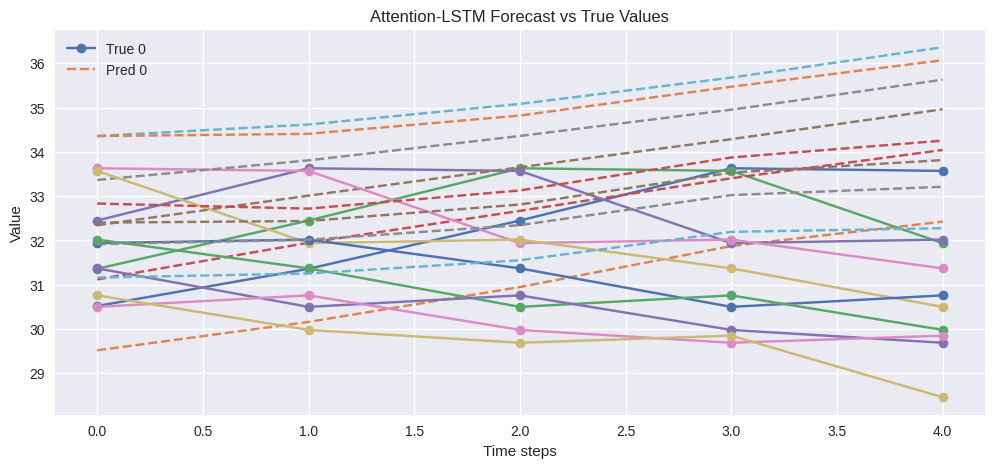

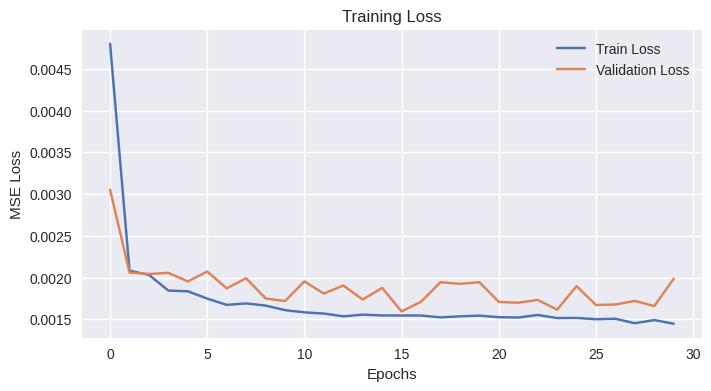

In [8]:
BATCH_SIZE = 32
EPOCHS = 30

history = model.fit([X_train, decoder_train], y_train,
                    validation_split=0.1, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1)

y_pred_scaled = model.predict([X_test, decoder_test])
y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1,1)).reshape(y_pred_scaled.shape)
y_true = scaler.inverse_transform(y_test.reshape(-1,1)).reshape(y_test.shape)

# Plot predictions
plt.figure(figsize=(12,5))
for i in range(min(10, y_test.shape[0])):
    plt.plot(range(horizon), y_true[i], marker='o', label=f"True {i}" if i==0 else "")
    plt.plot(range(horizon), y_pred[i], marker='x', linestyle='--', label=f"Pred {i}" if i==0 else "")
plt.title("Attention-LSTM Forecast vs True Values")
plt.xlabel("Time steps")
plt.ylabel("Value")
plt.legend()
plt.show()

# Loss curve
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()


In [9]:
vanilla_model = Sequential()
vanilla_model.add(LSTM(64, input_shape=(X_train.shape[1],1)))
vanilla_model.add(Dense(horizon))
vanilla_model.compile(optimizer='adam', loss='mse')

y_train_vanilla = y_train.reshape(y_train.shape[0], horizon)

vanilla_model.fit(X_train, y_train_vanilla, validation_split=0.1,
                  epochs=30, batch_size=32, verbose=1)

y_vanilla_scaled = vanilla_model.predict(X_test)
y_vanilla = scaler.inverse_transform(y_vanilla_scaled.reshape(-1,1)).reshape(y_test.shape)


Epoch 1/30


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0086 - val_loss: 0.0036
Epoch 2/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0023 - val_loss: 0.0025
Epoch 3/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0024 - val_loss: 0.0026
Epoch 4/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 5/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0018 - val_loss: 0.0021
Epoch 6/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0019 - val_loss: 0.0020
Epoch 7/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0019 - val_loss: 0.0021
Epoch 8/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0019 - val_loss: 0.0020
Epoch 9/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.0017 - val_loss: 0.0019
Epoch 10/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 11/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0016 - val_loss: 0.0019
Epoch 12/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0016 - val_l

In [14]:
# =========================
# SECTION 8: Metrics Comparison (Fixed)
# =========================

def compute_metrics(y_true, y_pred):
    """
    Computes MAE, RMSE, MAPE for multi-step forecasts
    y_true, y_pred: shape (samples, horizon)
    """
    mae = mean_absolute_error(y_true.flatten(), y_pred.flatten())
    rmse = np.sqrt(mean_squared_error(y_true.flatten(), y_pred.flatten()))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mae, rmse, mape

# Flatten last dimension if exists
if y_pred.ndim == 3:
    y_pred_flat = y_pred.reshape(y_pred.shape[0], y_pred.shape[1])
else:
    y_pred_flat = y_pred

if y_vanilla.ndim == 3:
    y_vanilla_flat = y_vanilla.reshape(y_vanilla.shape[0], y_vanilla.shape[1])
else:
    y_vanilla_flat = y_vanilla

# Compute metrics
att_mae, att_rmse, att_mape = compute_metrics(y_true, y_pred_flat)
van_mae, van_rmse, van_mape = compute_metrics(y_true, y_vanilla_flat)

metrics_df = pd.DataFrame({
    'Model':['Attention-LSTM','Vanilla-LSTM'],
    'MAE':[att_mae, van_mae],
    'RMSE':[att_rmse, van_rmse],
    'MAPE':[att_mape, van_mape]
})
print(metrics_df)


            Model       MAE      RMSE      MAPE
0  Attention-LSTM  1.798007  3.235183  9.188999
1    Vanilla-LSTM  1.604326  2.836013  8.249845


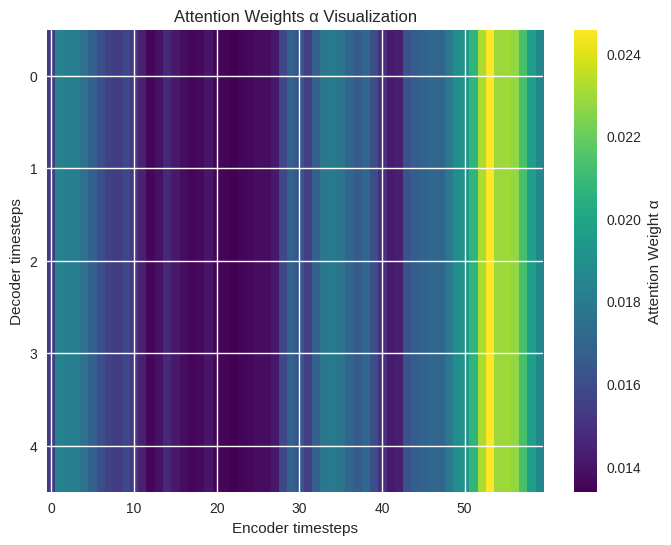

In [12]:
sample_idx = 0
encoder_out_sample = encoder_lstm(tf.convert_to_tensor(X_test[sample_idx:sample_idx+1]))[0]
decoder_state_h_sample = tf.convert_to_tensor(np.zeros((1, dec_units)))

attention_alphas = []

for t in range(horizon):
    hidden_with_time = tf.expand_dims(decoder_state_h_sample,1)
    score = attention.V(tf.nn.tanh(attention.W1(encoder_out_sample) + attention.W2(hidden_with_time)))
    alpha = tf.nn.softmax(score, axis=1)
    attention_alphas.append(alpha.numpy().flatten())

attention_alphas = np.stack(attention_alphas, axis=0)
plt.figure(figsize=(8,6))
plt.imshow(attention_alphas, cmap='viridis', aspect='auto')
plt.colorbar(label='Attention Weight α')
plt.xlabel('Encoder timesteps')
plt.ylabel('Decoder timesteps')
plt.title('Attention Weights α Visualization')
plt.show()


            Model        MAE       RMSE       MAPE
0  Attention-LSTM   1.798007   3.235183   9.188999
1    Vanilla-LSTM   1.604326   2.836013   8.249845
2         Prophet  17.653231  18.271409  99.493659


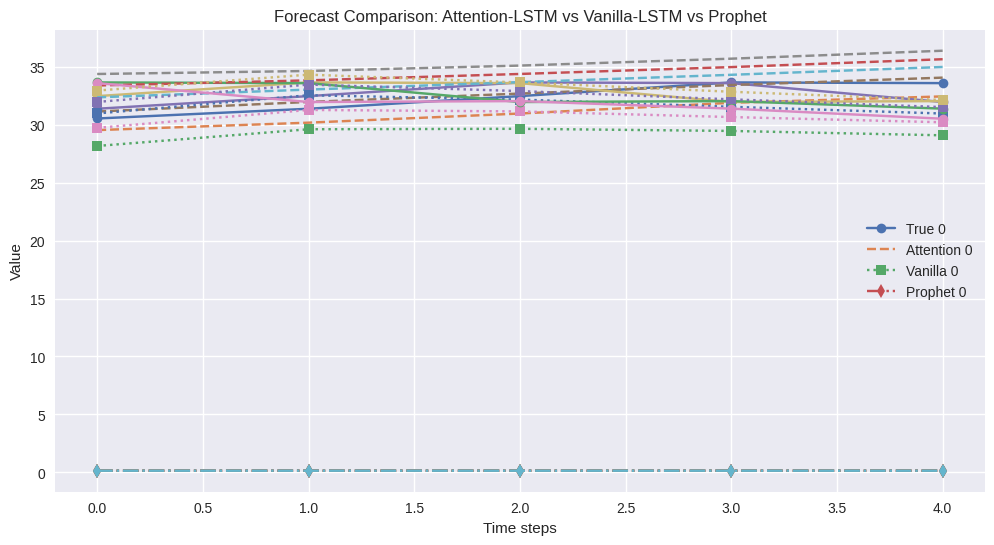

In [17]:
# =========================
# SECTION 10: Prophet Baseline (Fixed for pandas ≥ 2.0)
# =========================

# Flatten y for Prophet
y_series = y.reshape(-1)  # shape (num_samples * horizon,)

# Generate safe dates aligned with trading days
start_date = df['date'].iloc[LOOKBACK]  # first date after LOOKBACK
prophet_dates = pd.date_range(start=start_date, periods=len(y_series), freq='B')

prophet_df = pd.DataFrame({
    'ds': prophet_dates,
    'y': y_series
})

# Train-test split
train_len = int(len(prophet_df) * 0.8)
train_df = prophet_df.iloc[:train_len]
test_df  = prophet_df.iloc[train_len:]

# Fit Prophet model
prophet_model = Prophet(daily_seasonality=True)
prophet_model.fit(train_df)

# Forecast for test period
future = prophet_model.make_future_dataframe(periods=len(test_df), freq='B')
forecast = prophet_model.predict(future)

# Extract predicted yhat for test
y_prophet_series = forecast['yhat'].values[-len(test_df):]

# Reshape to match (samples, horizon)
num_test_samples = y_test.shape[0]
y_prophet = y_prophet_series.reshape(num_test_samples, horizon)

# Compute metrics
prophet_mae, prophet_rmse, prophet_mape = compute_metrics(y_true, y_prophet)

# Add Prophet metrics using pd.concat
prophet_metrics_df = pd.DataFrame({
    'Model': ['Prophet'],
    'MAE': [prophet_mae],
    'RMSE': [prophet_rmse],
    'MAPE': [prophet_mape]
})

metrics_df = pd.concat([metrics_df, prophet_metrics_df], ignore_index=True)
print(metrics_df)

# Plot comparison
plt.figure(figsize=(12,6))
for i in range(min(5, y_test.shape[0])):
    plt.plot(range(horizon), y_true[i], marker='o', label=f"True {i}" if i==0 else "")
    plt.plot(range(horizon), y_pred_flat[i], marker='x', linestyle='--', label=f"Attention {i}" if i==0 else "")
    plt.plot(range(horizon), y_vanilla_flat[i], marker='s', linestyle=':', label=f"Vanilla {i}" if i==0 else "")
    plt.plot(range(horizon), y_prophet[i], marker='d', linestyle='-.', label=f"Prophet {i}" if i==0 else "")
plt.title("Forecast Comparison: Attention-LSTM vs Vanilla-LSTM vs Prophet")
plt.xlabel("Time steps")
plt.ylabel("Value")
plt.legend()
plt.show()
